- Using frozen SimCLR as backbone, then bottleneck layer (maybe linear) trained on SimCLR features with MaxEnt loss
- Test SimCLR features here for few shot segmentation vs. e.g. linear layer classification

# Init

In [1]:
import numpy as np
import sys
import os
import torch
import torch.optim as optim
import pandas as pd
import torch.nn.functional as F

import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.animation as animation

dframe = pd.DataFrame

#%matplotlib notebook
#%matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..

/home/heka/code/retrieval_app


# SimCLR

In [2]:
from core.resnet_wider import resnet50x4

with torch.no_grad():
    repnet = resnet50x4().cuda()
repnet.eval()
print()

repnet_pth = '/home/heka/model_data/resnet50-4x.pth'
state_dict = torch.load(repnet_pth)['state_dict']
repnet.load_state_dict(state_dict)

<All keys matched successfully>

## Test with OpenImages:

In [50]:
if 1:  # validation set
    class_names_bbox = pd.read_csv('https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv',header=None).to_dict()
    class_names_seg = pd.read_csv('https://storage.googleapis.com/openimages/v5/classes-segmentation.txt', header=None).to_dict()
    df_masks = pd.read_csv('https://storage.googleapis.com/openimages/v5/validation-annotations-object-segmentation.csv')
    image_meta = pd.read_csv('https://storage.googleapis.com/openimages/2018_04/validation/validation-images-with-rotation.csv')

    mask_root = '/media/heka/TERA/Data/openimages_val_masks'

idx2name_bbox = class_names_bbox[0]
name2idx_bbox = {val: key for key, val in idx2name_bbox.items()}
idx2description_bbox = class_names_bbox[1]
description2idx_bbox = {val: key for key, val in idx2description_bbox.items()}
idx2name_seg = class_names_seg[0]
name2idx_seg = {val: key for key, val in idx2name_seg.items()}
num_classes_seg = len(class_names_seg[0])

In [49]:
image_meta.head()

,ImageID,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL,Rotation
0,fe600639ac5f36c1,validation,https://farm2.staticflickr.com/5612/1534025949...,https://www.flickr.com/photos/118815643@N04/15...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/118815643@N04/,LabHacker CD,_GUT6674,242145,0jBpbNION09+r02xkTIBcA==,https://c8.staticflickr.com/6/5612/15340259497...,NaN
1,ba82c70cc6cdf449,validation,https://farm4.staticflickr.com/3859/1527670200...,https://www.flickr.com/photos/125612851@N04/15...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/125612851@N04/,Stockholms stadsarkiv,SE_SSA_0870_Ofört_029,1658910,qMzF2UrrpPdjO+Nhhl6pvQ==,https://c7.staticflickr.com/4/3859/15276702002...,0.0
2,e3ffa4c868b11b15,validation,https://farm6.staticflickr.com/5336/1717037798...,https://www.flickr.com/photos/101125222@N02/17...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/101125222@N02/,Ismaïl Taha,ct26,1085575,MXOLnofbdq410OH34woSeg==,https://c3.staticflickr.com/6/5336/17170377986...,0.0
3,7d00af2927a57eeb,validation,https://c4.staticflickr.com/7/6181/6085189538_...,https://www.flickr.com/photos/66833578@N02/608...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/66833578@N02/,Crycks,Hummingbird,126933,m0dy5a3Pjhbzx15MbScpxg==,https://c5.staticflickr.com/7/6181/6085189538_...,0.0
4,914dd6fb5eb17e85,validation,https://farm6.staticflickr.com/3324/4621899397...,https://www.flickr.com/photos/damo1977/4621899397,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/damo1977/,damo1977,"Christmas 1994 Hoticulture, Nuts & Dried Fruit...",855508,xeHPBJGWTrDVbOufALMFGw==,https://c6.staticflickr.com/4/3324/4621899397_...,NaN


In [112]:
# interesting fashion/prod search segmentation classes:
seg_interesting_classes = ['Clothing', 'Dress', 'Lipstick', 'Luggage and bags', 'Belt', 'Pen', 'Couch', 'Oven', 'High heels', 
                           'Suit', 'Backpack', 'Suitcase', 'Clock', 'Scarf', 'Camera', 'Handbag', 'Swim cap', 'Jeans', 'Plastic bag', 
                          'Hat', 'Baseball glove', 'Sun hat', 'Briefcase', 'Sock', 'Shirt', 'Glove', 'Towel', 'Fedora', 'Sombrero',
                          'Cowboy hat', 'Watch', 'Shorts', 'Skirt', 'Miniskirt']

Number of masks with class "Dress" = 278
https://c5.staticflickr.com/3/2949/15269001397_e375f5284e_z.jpg


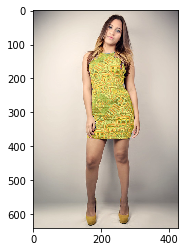

In [111]:
import os
from PIL import Image

from core.dataio import image_from_url

cls_this = 'Dress'
id_item = 4


idx = description2idx_bbox[cls_this]
name = idx2name_bbox[idx]

df_masks_name = df_masks[df_masks.LabelName == name]
print(f'Number of masks with class "{cls_this}" = {len(df_masks_name)}')

mask_path = df_masks_name.MaskPath.values[id_item]
image_id = df_masks_name.ImageID.values[id_item]
mask_path = os.path.join(mask_root, mask_path)
image_url = image_meta[image_meta.ImageID == image_id].OriginalURL.values[0]
image_url = image_url.replace('_o.jpg', '_z.jpg')  # lower res
print(image_url)

mask = Image.open(mask_path)
img = image_from_url(image_url)

# resize mask to img shape:
h = img.height
w = img.width
mask = np.array(mask.resize(img.size))
mask_plt = mask.copy().astype(np.float32)
mask_plt[mask_plt == False] = np.nan
img = np.array(img)

assert img.shape[:-1] == mask.shape

plt.imshow(img)
plt.imshow(mask_plt, vmin=0.5, alpha=0.5)
plt.show()

### Number of interesting class examples:

In [119]:
if 1:  # training set
    df_masks = pd.read_csv('https://storage.googleapis.com/openimages/v5/train-annotations-object-segmentation.csv')  # takes a while to load...

numbers = list()
for i, seg_cls in enumerate(seg_interesting_classes):
    #print(f'\r{i}', end='')
    idx = description2idx_bbox[seg_cls]
    name = idx2name_bbox[idx]
    df_masks_name = df_masks[df_masks.LabelName == name]
    num = len(df_masks_name)
    numbers.append(num)
    print(f'{seg_cls} : {num}')


Clothing : 414489
Dress : 47605
Lipstick : 821
Luggage and bags : 1910
Belt : 386
Pen : 1443
Couch : 4072
Oven : 609
High heels : 2522
Suit : 100410
Backpack : 1082
Suitcase : 586
Clock : 977
Scarf : 2155
Camera : 5094
Handbag : 2294
Swim cap : 482
Jeans : 61076
Plastic bag : 839
Hat : 10715
Baseball glove : 1461
Sun hat : 5742
Briefcase : 147
Sock : 1222
Shirt : 7168
Glove : 1022
Towel : 260
Fedora : 3178
Sombrero : 600
Cowboy hat : 2556
Watch : 1724
Shorts : 12613
Skirt : 1055
Miniskirt : 857


## Database:

In [5]:
from core.dataio import Database
from core.dataio import image_from_url
from core.augs import load_augs
from pprint import pprint
from detectron2.data import MetadataCatalog, DatasetCatalog

catalog = MetadataCatalog.get('coco_2017_train_panoptic_separated')
thing_classes = catalog.thing_classes
stuff_classes = catalog.stuff_classes
imagenet_classes = pd.read_csv('/home/heka/code/simclr-converter/metadata/imagenet_classes.txt', header=None, index_col=[0])

db_path = 'open-images-dataset-train0_0_475000.h5'
database = Database(db_path, mode='r', title=None)

augs = load_augs(resize_to=256)

Trying to load database from /home/heka/model_data/open-images-dataset-train0_0_475000.h5


index=341096
{'h': 0.1282,
 'is_thing': True,
 'pred': b'person',
 'url': b'https://c6.staticflickr.com/9/8264/8661741318_8d8ed2e82d_z.jpg',
 'w': 0.6206}


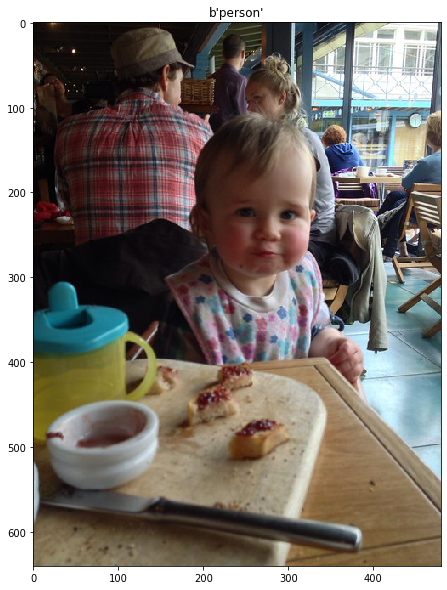

In [11]:
i = np.random.randint(400000)
#i = 60449
print(f'index={i}')

code, entity = database[i]
pprint(entity)

pred = entity['pred']
pred_h = entity['h']
pred_w = entity['w']
is_thing = entity['is_thing']

img = image_from_url(entity['url'])
#img = augs['augs_base'](img)
img_np = np.array(img)
h, w = img_np.shape[:-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.title(pred)
ax.imshow(img_np)
plt.show()

In [7]:
entity

{'h': 0.6562,
 'is_thing': True,
 'pred': b'person',
 'url': b'https://c4.staticflickr.com/4/3184/2841807128_f00fd1ef8a_z.jpg',
 'w': 0.533}

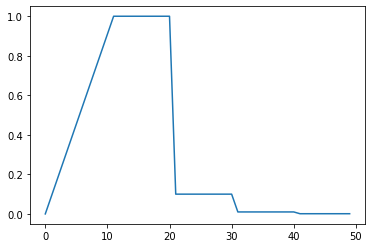

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from munch import Munch

args = Munch(warmup_peak=10,
            decay_at_epochs=[20, 30, 40],
            lr_decay_gamma=0.1)

def lr_lambda(step):
    warmup_peak = args.warmup_peak
    decay_at_epochs = np.array(args.decay_at_epochs)
    gamma = args.lr_decay_gamma
    assert warmup_peak < np.min(decay_at_epochs)
    if step <= warmup_peak:
        return step / (warmup_peak + 1)
    else:
        stage = np.sum(step > decay_at_epochs)
        return gamma ** stage
    
vals = list()
for step in np.arange(50):
    vals.append(lr_lambda(step))
    
plt.plot(vals)

In [45]:
decay_at_epochs = np.array([20, 30, 40])
gamma = 25

stage = np.sum(gamma > decay_at_epochs)
print(stage)



1


In [34]:
gamma > decay_at_epochs

array([ True, False, False])